In [1]:
import argparse
import os
import pickle
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pyabc
#from pyabc.sampler import RedisEvalParallelSampler
import scipy.stats as stats
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics

from load_bayesflow_model import load_model
from plotting_routines import plot_compare_summary_stats, plot_trajectory, \
    plot_autocorrelation, sampling_parameter_cis, plot_posterior_2d, plot_sumstats_distance_hist
from summary_stats import reduced_coordinates_to_sumstat, reduce_to_coordinates, \
    compute_mean_summary_stats, compute_MSD_lags

/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# get the job array id and number of processors
job_array_id = int(os.environ.get('SLURM_ARRAY_TASK_ID', 0))
n_procs = int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
print(job_array_id)
on_cluster = False
population_size = 1000
load_synthetic_data = False

if on_cluster:
    parser = argparse.ArgumentParser(description='Parse necessary arguments')
    parser.add_argument('-pt', '--port', type=str, default="50004",
                        help='Which port should be use?')
    parser.add_argument('-ip', '--ip', type=str,
                        help='Dynamically passed - BW: Login Node 3')
    args = parser.parse_args()

0


In [3]:
if on_cluster:
    gp = '/home/jarruda_hpc/CellMigration/synth_data_params_bayesflow'
else:
    gp = os.getcwd()

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',
    'move.duration.mean': './CellTypes/CellType/Constant[@symbol="move.duration.mean"]',
    'cell_nodes_real': './Global/Constant[@symbol="cell_nodes_real"]',
}

model_path = gp + "/cell_movement_v24.xml"  # time step is 30sec
#model_path = gp + "/cell_movement_v24-no-pillars.xml"  # for simulation without pillars
#model_path = gp + "/cell_movement_v24-no-chemokine.xml"  # for simulation without chemokine
#model_path = gp + "/cell_movement_v24-no-chemokine-no-pillars.xml"  # for simulation without chemokine and without pillars
#model_path = gp + "/cell_movement_v24-no-persistent.xml"  # for simulation without persistent random walk
#model_path = gp + "/cell_movement_v24-no-persistent-no-pillars.xml"  # for simulation without persistent random walk and without pillars
# defining the summary statistics function
max_sequence_length = 120
min_sequence_length = 0
only_longest_traj_per_cell = True  # mainly to keep the data batchable
cells_in_population = 50


def make_sumstat_dict(data: Union[dict, np.ndarray]) -> dict:
    if isinstance(data, dict):
        # get key
        key = list(data.keys())[0]
        data = data[key]
    data = data[0]  # only one sample
    # compute the summary statistics
    summary_stats_dict = reduced_coordinates_to_sumstat(data)
    (ad_mean, _, msd_mean, _, ta_mean, _, vel_mean, _, wt_mean, _) = compute_mean_summary_stats([summary_stats_dict], remove_nan=False)
    cleaned_dict = {
        'ad': np.array(ad_mean).flatten(),
        'msd': np.array(msd_mean).flatten(),
        'ta': np.array(ta_mean).flatten(),
        'vel': np.array(vel_mean).flatten(),
        'wt': np.array(wt_mean).flatten()
    }
    return cleaned_dict


def prepare_sumstats(output_morpheus_model) -> dict:
    sim_coordinates = reduce_to_coordinates(output_morpheus_model, 
                          minimal_length=min_sequence_length, 
                          maximal_length=max_sequence_length,
                          only_longest_traj_per_cell=only_longest_traj_per_cell
                          )
    
    # we now do exactly the same as in the BayesFlow workflow, but here we get only one sample at a time
    data_transformed = np.ones((1, cells_in_population, max_sequence_length, 2)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    n_cells_not_visible = 0
    if len(sim_coordinates) != 0:
        # some cells were visible in the simulation
        for c_id, cell_sim in enumerate(sim_coordinates):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data_transformed[0, c_id, -len(cell_sim['x']):, 0] = cell_sim['x']
            data_transformed[0, c_id, -len(cell_sim['y']):, 1] = cell_sim['y']
    
    return {'sim': data_transformed}


sumstat = SummaryStatistics(sum_stat_calculator=prepare_sumstats)                    

if on_cluster:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # todo: remember also change tiff path in model.xml!
else:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

# parameter values used to generate the synthetic data
obs_pars = {
    'gradient_strength': 100.,  # strength of the gradient of chemotaxis
    'move.strength': 10.,  # strength of directed motion
    'move.duration.mean': 0.1,  # mean of exponential distribution (seconds)
    'cell_nodes_real': 50.,  # volume of the cell (\mu m^2)
}


obs_pars_log = {key: np.log10(val) for key, val in obs_pars.items()}
limits = {'gradient_strength': (1, 10000), #(10 ** 4, 10 ** 8),
          'move.strength': (1, 100),
          'move.duration.mean': (1e-4, 30), #(math.log10((10 ** -2) * 30), math.log10((10 ** 4))), # smallest time step in simulation 5
          'cell_nodes_real': (1, 300)}
limits_log = {key: (np.log10(val[0]), np.log10(val[1])) for key, val in limits.items()}


prior = pyabc.Distribution(**{key: pyabc.RV("uniform", loc=lb, scale=ub-lb)
                              for key, (lb, ub) in limits_log.items()})
param_names = list(obs_pars.keys())
log_param_names = [f'log_{p}' for p in param_names]
print(obs_pars)
print(limits_log)

{'gradient_strength': 100.0, 'move.strength': 10.0, 'move.duration.mean': 0.1, 'cell_nodes_real': 50.0}
{'gradient_strength': (0.0, 4.0), 'move.strength': (0.0, 2.0), 'move.duration.mean': (-4.0, 1.4771212547196624), 'cell_nodes_real': (0.0, 2.4771212547196626)}


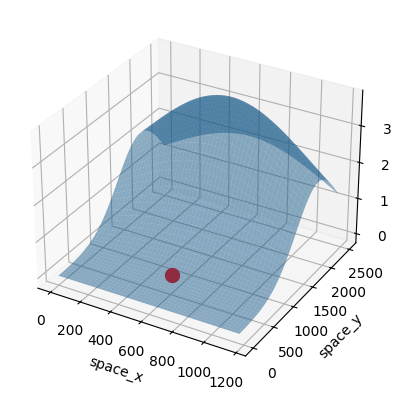

(586.5, 572.5190839694657, 1.801794707907847e-07, 3.68292430295295e-06)

In [4]:
sigma0 = 550
space_x0 = 1173/2
space_y0 = 1500/1.31/2
x0, y0 = 1173/2, (1500+1500/2+270)/1.31
u1 = lambda space_x, space_y: 7/(2*np.pi*(sigma0**2)) *np.exp(-1/2*(((space_x)-(x0))**2+ ((space_y)-(y0))**2)/(sigma0**2))

# plot the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0, 1173 , 100)
y = np.linspace(0, 2500 , 100)
X, Y = np.meshgrid(x, y)
Z = u1(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.5)
# plot start points
ax.scatter(space_x0, space_y0, u1(space_x0, space_y0), color='r', s=100)

ax.set_xlabel('space_x')
ax.set_ylabel('space_y')
plt.show()

space_x0, space_y0, u1(space_x0, space_y0), u1(x0, y0)

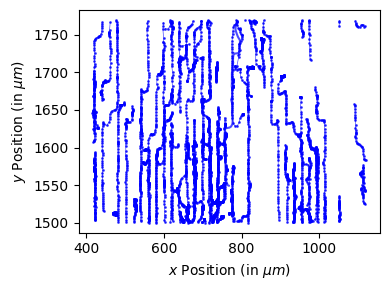

(1, 50, 120, 2)

In [65]:
if load_synthetic_data:
    # simulate test data
    test_params = np.array(list(obs_pars_log.values()))
    if not os.path.exists(os.path.join(gp, 'test_sim.npy')):
        raise FileNotFoundError('Test data not found')
    else:
        test_sim = np.load(os.path.join(gp, 'test_sim.npy'))
        
    results_path = 'abc_results'
else:
    # load real data
    from load_data import load_real_data
    test_params = None
    real_data, real_data_full = load_real_data(data_id=1, 
                                               max_sequence_length=max_sequence_length, 
                                               cells_in_population=cells_in_population)
    factor = 1.31  # convert from Morpheus to real coordinates in micrometers
    real_data = real_data * factor  # when loading the data, it is converted to Morpheus coordinates for ABC
    real_data_full = real_data_full * factor  # when loading the data, it is converted to Morpheus coordinates for ABC


    test_sim = np.array([real_data[start:start+cells_in_population] for start in range(0, len(real_data), cells_in_population)])[0][np.newaxis]
    results_path = 'abc_results_real'

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True,
                       tight_layout=True, figsize=(4, 3))
    plt.plot(real_data_full[0, :, 0], real_data_full[0, :, 1], color='blue', alpha=0.7)
    for cell_id in range(1, real_data_full.shape[0]):
        plt.plot(real_data_full[cell_id, :, 0], real_data_full[cell_id, :, 1], linewidth=0.5, color='blue', alpha=0.7)
        plt.scatter(real_data_full[cell_id, :, 0], real_data_full[cell_id, :, 1], s=1, color='blue', alpha=0.7)

    plt.ylabel('$y$ Position (in $\mu m$)')
    plt.xlabel('$x$ Position (in $\mu m$)')
    #plt.savefig(os.path.join(gp, f'{results_path}/real_data.png'), bbox_inches='tight')
    plt.show()

test_sim.shape

In [6]:
# load bayesflow posterior samples
if load_synthetic_data:
    bayesflow_posterior_samples = np.load(f'amortizer-cell-migration-attention-8-manual/posterior_samples_synthetic.npy')
    posterior_sim_abc = np.load(os.path.join(gp, f'{results_path}/posterior_sim_abc.npy'))
else:
    #bayesflow_posterior_samples = np.load(f'amortizer-cell-migration-attention-8-manual/posterior_samples_real.npy')
    bayesflow_posterior_samples = np.load(f'amortizer-cell-migration-ensemble/posterior_samples_real.npy')
    #bayesflow_posterior_samples = np.load(f'amortizer-cell-migration-attention-8-manual-include-real/posterior_samples_real.npy')
    #bayesflow_posterior_samples = np.load(f'amortizer-cell-migration-attention-8-manual-compare-real/posterior_samples_real.npy')
    posterior_sim_abc = None
bayesflow_median = np.median(bayesflow_posterior_samples, axis=0)

In [7]:
prior_draws = np.array([list(prior.rvs().values()) for _ in range(1000)])

## ABC with Wasserstein distance

In [8]:
def obj_func_wass(sim: dict, obs: dict, return_marginal: bool = False, normalize: bool = False):
    total = np.zeros(len(sim.keys()))
    for k_i, key in enumerate(sim):
        x, y = np.array(sim[key]), np.array(obs[key])
        if x.size == 0 or y.size == 0:
            return np.inf
        total[k_i] = stats.wasserstein_distance(x, y)
        if normalize:
            max_x = max(np.max(x), 1e-4)  # not y, to use the test data as reference
            total[k_i] = total[k_i] / max_x
    if return_marginal:
        return total
    return total.sum()

In [9]:
abc_posterior_samples = None
#redis_sampler = RedisEvalParallelSampler(host=args.ip, port=args.port,
#                                         adapt_look_ahead_proposal=False,
#                                         look_ahead=False)

abc = pyabc.ABCSMC(model, prior,
                   distance_function=obj_func_wass,
                   summary_statistics=make_sumstat_dict,
                   population_size=population_size,
                   sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=n_procs)
                   #sampler=redis_sampler
                   )

db_path = os.path.join(gp, f"{results_path}/{'synthetic' if load_synthetic_data else 'real'}_test_old_sumstats.db")
if not os.path.exists(db_path) and load_synthetic_data:  # not done for real data
    history = abc.new("sqlite:///" + db_path, make_sumstat_dict(test_sim))

    # start the abc fitting
    abc.run(min_acceptance_rate=1e-2, max_nr_populations=15)
    print('Done!')
elif load_synthetic_data:
    history = abc.load("sqlite:///" + db_path)
else:
    history = None

ABC.Sampler INFO: Parallelize sampling on 1 processes.
INFO:ABC.Sampler:Parallelize sampling on 1 processes.


AttributeError: 'NoneType' object has no attribute 'max_t'

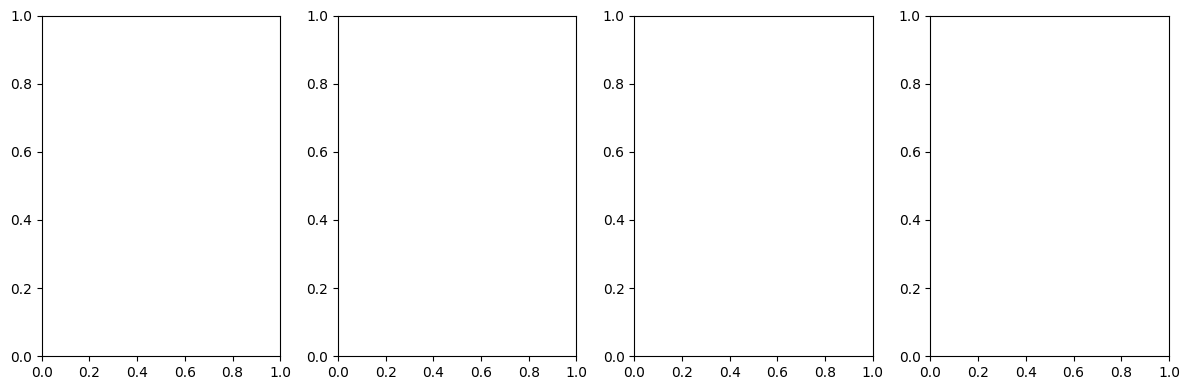

In [10]:
fig, ax = plt.subplots(1, len(param_names), tight_layout=True, figsize=(12, 4))
for i, param in enumerate(param_names):
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=limits_log[param][0],
            xmax=limits_log[param][1],
            x=param,
            xname=log_param_names[i],
            ax=ax[i],
            label=f"PDF t={t}",
        )
    ax[i].legend()
    ax[i].set_xlim((limits_log[param][0]-0.2, limits_log[param][1]+0.2))
plt.savefig(os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_population_kdes.png'))
plt.show()

fig, arr_ax = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
arr_ax = arr_ax.flatten()
pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0])
arr_ax[0].get_legend().remove()
#pyabc.visualization.plot_walltime(history, ax=arr_ax[1], unit='h')
pyabc.visualization.plot_epsilons(history, ax=arr_ax[1])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[2])
pyabc.visualization.plot_acceptance_rates_trajectory(history, ax=arr_ax[3])
# remove last axis
#arr_ax[-1].axis('off')
plt.savefig(os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_diagnostics.png'))
plt.show()

pyabc.visualization.plot_credible_intervals(history, levels=[0.95]);

In [ ]:
abc_df, abc_w = history.get_distribution()
abc_posterior_samples = pyabc.resample(abc_df[param_names].values, abc_w, n=1000)
abc_median = np.median(abc_posterior_samples, axis=0)

In [11]:
fig = plot_posterior_2d(posterior_draws=abc_posterior_samples,
                        prior_draws=prior_draws,
                        param_names=log_param_names,
                        true_params=test_params,
                        height=2.5)
plt.savefig(os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_posterior_vs_prior.png'))
plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
#w, sumstats = history.get_weighted_sum_stats()  # computed during ABC run
sumstats = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in posterior_sim_abc]  # computed after run

plot_sumstats_distance_hist(obj_func_wass, make_sumstat_dict(test_sim), [sumstats], #weights=w,
                            path=os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_sumstats_wasserstein.png'))

In [ ]:
# plot the summary statistics
plot_compare_summary_stats(test_sim, posterior_sim_abc); # path=f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_Summary Stats');

## ABC with neural network summary statistics

In [12]:
if os.path.exists(os.path.join(gp, 'validation_data.pickle')):
    with open(os.path.join(gp, 'validation_data.pickle'), 'rb') as f:
        valid_data = pickle.load(f)
else:
    raise FileNotFoundError('Validation data not found')

x_mean = np.nanmean(valid_data['sim_data'], axis=(0, 1, 2))
x_std = np.nanstd(valid_data['sim_data'], axis=(0, 1, 2))
p_mean = np.mean(valid_data['prior_draws'], axis=0)
p_std = np.std(valid_data['prior_draws'], axis=0)
print('Mean and std of data:', x_mean, x_std)
print('Mean and std of parameters:', p_mean, p_std)


# compute the mean of the summary statistics
summary_stats_list_ = [reduced_coordinates_to_sumstat(t) for t in valid_data['sim_data']]
(_, ad_averg, _, MSD_averg, _, TA_averg, _, VEL_averg, _, WT_averg) = compute_mean_summary_stats(summary_stats_list_, remove_nan=False)

direct_conditions_ = np.stack([ad_averg, MSD_averg, TA_averg, VEL_averg, WT_averg]).T
# replace inf with -1
direct_conditions_[np.isinf(direct_conditions_)] = np.nan
        
summary_valid_max = np.nanmax(direct_conditions_, axis=0)
summary_valid_min = np.nanmin(direct_conditions_, axis=0)

Mean and std of data: [ 584.8564567  1218.30836285] [48.56665046 59.88427128]
Mean and std of parameters: [ 1.95494199  0.99490352 -1.43414929  1.15144457] [1.13024234 0.57772408 1.38909074 0.76196229]


/Users/jonas.arruda/PyCharm Projects/CellMigration/synth_data_params_bayesflow/summary_stats.py:200: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/Users/jonas.arruda/PyCharm Projects/CellMigration/synth_data_params_bayesflow/summary_stats.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice.
  return np.nanvar(x)


In [13]:
# use trained neural net as summary statistics
def make_sumstat_dict_nn(
        data: Union[dict, np.ndarray],
) -> dict:
    if isinstance(data, dict):
        # get key
        key = list(data.keys())[0]
        data = data[key]

    trainer, map_idx_sim = load_model(
        model_id=5,
        x_mean=x_mean,
        x_std=x_std,
        p_mean=p_mean,
        p_std=p_std,
        summary_valid_max=summary_valid_max,
        summary_valid_min=summary_valid_min,
    )

    # configures the input for the network
    config_input = trainer.configurator({"sim_data": data})
    # get the summary statistics
    out_dict = {
        'summary_net': trainer.amortizer.summary_net(config_input['summary_conditions']).numpy().flatten()
    }
    # if direct conditions are available, concatenate them
    if 'direct_conditions' in config_input.keys():
        out_dict['direct_conditions'] = config_input['direct_conditions'].flatten()
        
    del trainer
    return out_dict


if on_cluster:
    # define the model object
    model_nn = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # todo: remember also change tiff path in model.xml!
else:
    # define the model object
    model_nn = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

In [14]:
%%time
synthetic_data_test_nn = make_sumstat_dict_nn(test_sim)
synthetic_data_test_nn

CPU times: user 661 ms, sys: 76.6 ms, total: 737 ms
Wall time: 692 ms


{'summary_net': array([-0.24812837, -0.20248257,  3.3640366 , -0.6202402 , -0.861728  ,
         1.1336342 ,  0.21359804,  0.42067537], dtype=float32),
 'direct_conditions': array([0.29307193, 0.01066099, 1.1565992 , 0.07554183, 0.14587201],
       dtype=float32)}

In [15]:
#redis_sampler = RedisEvalParallelSampler(host=args.ip, port=args.port,
#                                         adapt_look_ahead_proposal=False,
#                                         look_ahead=False)

abc_nn = pyabc.ABCSMC(model_nn, prior, # here we use now the Euclidean distance, Wasserstein distance is not possible
                      population_size=population_size,
                      summary_statistics=make_sumstat_dict_nn,
                      sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=n_procs)
                      #sampler=redis_sampler
                      )

db_path = os.path.join(gp, f"{results_path}/{'synthetic' if load_synthetic_data else 'real'}_test_nn_sumstats.db")

if not os.path.exists(db_path):
    history_nn = abc_nn.new("sqlite:///" + db_path, make_sumstat_dict_nn(test_sim))

    # start the abc fitting
    abc_nn.run(min_acceptance_rate=1e-2, max_nr_populations=15)
    print('Done!')
else:
    history_nn = abc_nn.load("sqlite:///" + db_path)

ABC.Sampler INFO: Parallelize sampling on 1 processes.
INFO:ABC.Sampler:Parallelize sampling on 1 processes.


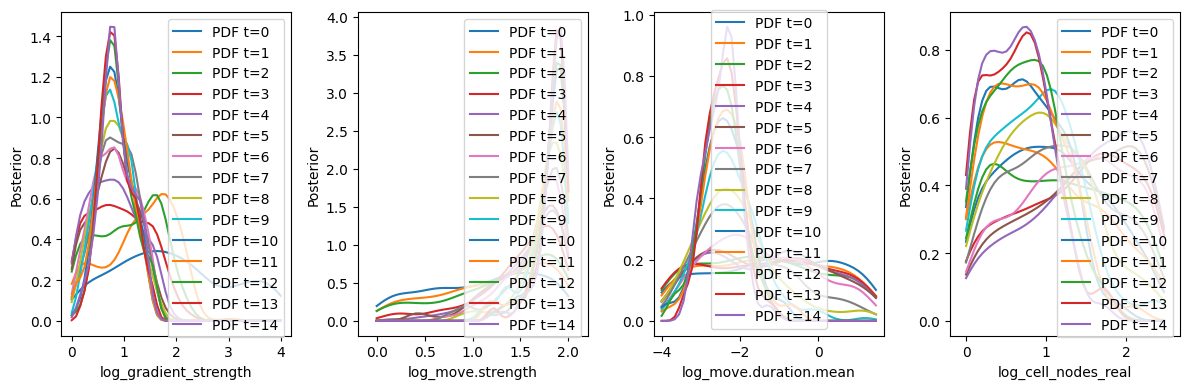

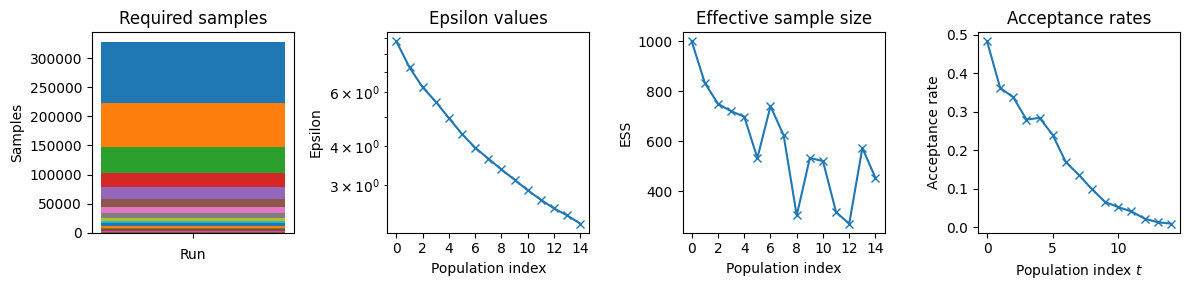

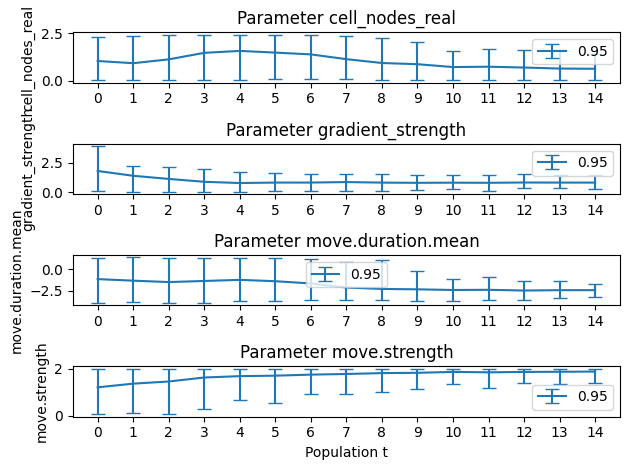

In [16]:
fig, ax = plt.subplots(1, len(param_names), tight_layout=True, figsize=(12, 4))
for i, param in enumerate(param_names):
    for t in range(history_nn.max_t + 1):
        df, w = history_nn.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=limits_log[param][0],
            xmax=limits_log[param][1],
            x=param,
            xname=log_param_names[i],
            ax=ax[i],
            label=f"PDF t={t}",
        )
    ax[i].legend()
    ax[i].set_xlim((limits_log[param][0]-0.2, limits_log[param][1]+0.2))
plt.savefig(os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_population_kdes_nn.png'))
plt.show()

fig, arr_ax = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
arr_ax = arr_ax.flatten()
pyabc.visualization.plot_sample_numbers(history_nn, ax=arr_ax[0])
arr_ax[0].get_legend().remove()
#pyabc.visualization.plot_walltime(history_nn, ax=arr_ax[1], unit='h')
pyabc.visualization.plot_epsilons(history_nn, ax=arr_ax[1])
pyabc.visualization.plot_effective_sample_sizes(history_nn, ax=arr_ax[2])
pyabc.visualization.plot_acceptance_rates_trajectory(history_nn, ax=arr_ax[3])
# remove last axis
#arr_ax[-1].axis('off')
plt.savefig(os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_diagnostics_nn.png'))
plt.show()

pyabc.visualization.plot_credible_intervals(history_nn, levels=[0.95]);

In [17]:
abc_df, abc_w = history_nn.get_distribution()
abc_posterior_samples_nn = pyabc.resample(abc_df[param_names].values, abc_w, n=1000)
abc_nn_median = np.median(abc_posterior_samples_nn, axis=0)

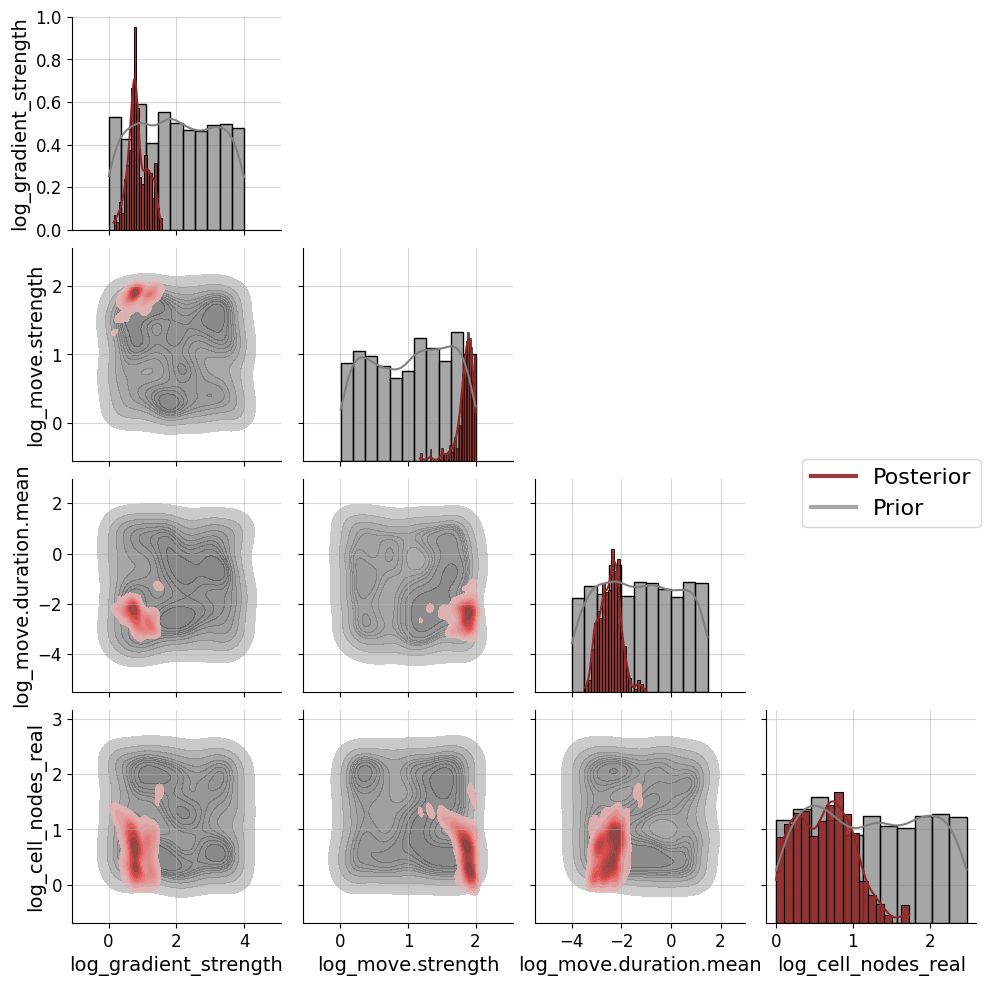

In [18]:
fig = plot_posterior_2d(posterior_draws=abc_posterior_samples_nn,
                        prior_draws=prior_draws,
                        param_names=log_param_names,
                        true_params=test_params,
                        height=2.5)
plt.savefig(os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_posterior_vs_prior_nn_summary.png'))
plt.show()

In [19]:
if abc_posterior_samples is not None:
    colors = ['#e66101', '#5e3c99', '#fdb863', '#b2abd2']

    # Compute means and standard deviations
    prior_mean = np.mean(prior_draws, axis=0)
    posterior_mean_a = np.mean(abc_posterior_samples, axis=0)
    posterior_mean_b = np.mean(abc_posterior_samples_nn, axis=0)
    prior_std = np.std(prior_draws, axis=0)
    posterior_std_a = np.std(abc_posterior_samples, axis=0)
    posterior_std_b = np.std(abc_posterior_samples_nn, axis=0)

    # Calculate z-scores and contractions
    z_scores_a = (posterior_mean_a - prior_mean) / prior_std
    z_scores_b = (posterior_mean_b - prior_mean) / prior_std
    contractions_a = 1 - (posterior_std_a / prior_std)
    contractions_b = 1 - (posterior_std_b / prior_std)

    # Plotting Z-scores and contractions for both methods
    fig, ax1 = plt.subplots(figsize=(8, 3), tight_layout=True)

    # Z-Scores for both methods
    ax1.bar(range(len(param_names)), z_scores_a, width=0.4, label='Z-Score ABC', alpha=0.5, align='center')
    ax1.bar(np.arange(len(param_names)) + 0.4, z_scores_b, width=0.4, label='Z-Score ABC-NN', alpha=0.5, align='center')
    #ax1.set_xlabel('Parameter')
    ax1.set_ylabel('Z-Score')
    ax1.tick_params(axis='y')
    ax1.set_xticks(np.arange(len(param_names)) + 0.2)
    ax1.set_xticklabels(log_param_names)
    ax1.axhline(0, color='gray', linestyle='--', linewidth=0.8)

    # Plot Contractions for both methods on secondary axis
    ax2 = ax1.twinx()
    ax2.plot(np.arange(0.2, len(param_names)), contractions_a, alpha=0.5, marker='o', label='Contraction ABC', linestyle='--')
    ax2.plot(np.arange(0.2, len(param_names)), contractions_b, alpha=0.5, marker='o', label='Contraction ABC-NN', linestyle='--')
    ax2.set_ylabel('--●--  Contraction')
    ax2.tick_params(axis='y')

    # Combine legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    #handles2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(handles1, ['ABC Hand-Crafted Summaries', 'ABC Neural Summaries'], loc='lower center', bbox_to_anchor=(0.5, -0.07), ncol=4)
    #fig.suptitle(f'Comparison of Z-Scores and Contraction')
    fig.savefig(os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_z_scores_contraction.png'), bbox_inches='tight')
    plt.show()

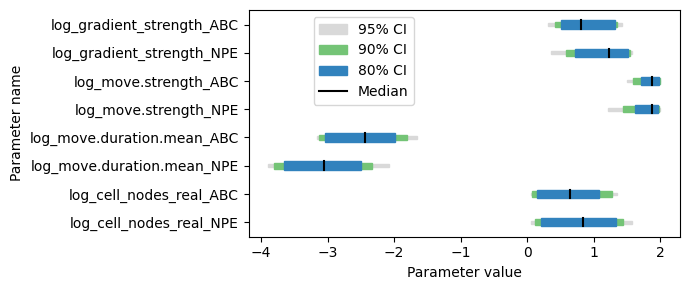

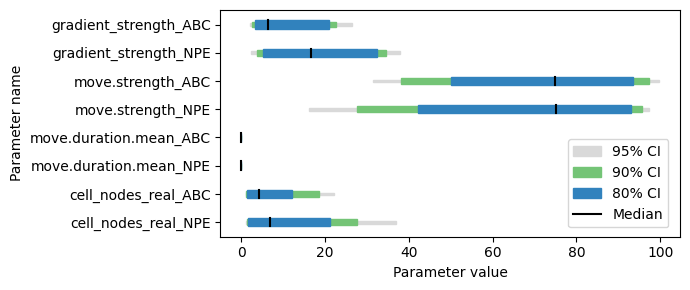

In [20]:
ordering = [0,4,1,5,2,6,3,7]
all_params = np.concatenate((abc_posterior_samples_nn, bayesflow_posterior_samples), axis=-1)
#all_params = np.power(10, all_params)

ax = sampling_parameter_cis(
    all_params[:, ordering],
    true_param=np.concatenate((test_params, test_params))[ordering] if test_params is not None else None,
    param_names=np.array(
        [f'{n}_ABC' for n in log_param_names] +  [f'{n}_NPE' for n in log_param_names]
    )[ordering],
    alpha=[95, 90 , 80],
    show_median=False if test_params is not None else True,
    size=(7, 3),
    legend_bbox_to_anchor=(0.4,1)
)
plt.savefig(os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_posterior_credible_intervals_log.png'))
plt.show()

all_params = np.power(10, all_params)
ax = sampling_parameter_cis(
    all_params[:, ordering],
    true_param=np.power(10, np.concatenate((test_params, test_params))[ordering]) if test_params is not None else None,
    param_names=np.array(
        [f'{n}_ABC' for n in param_names] +  [f'{n}_NPE' for n in param_names]
    )[ordering],
    alpha=[95, 90 , 80],
    show_median=False if test_params is not None else True,
    size=(7, 3),
    legend_bbox_to_anchor=(0.99,0.46)
)
plt.savefig(os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_posterior_credible_intervals.png'))
plt.show()

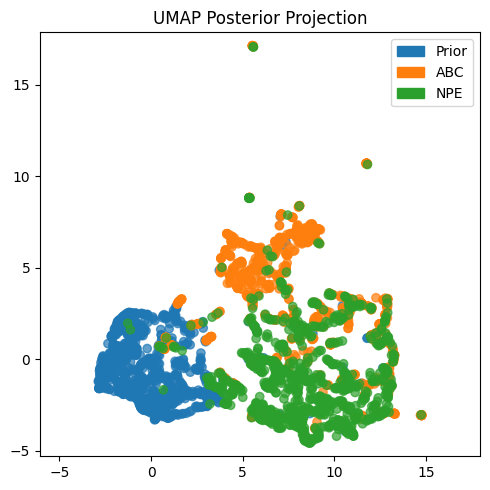

In [21]:
all_samples = np.concatenate([
    prior_draws[:bayesflow_posterior_samples.shape[0]],
    abc_posterior_samples_nn[:bayesflow_posterior_samples.shape[0]],
    bayesflow_posterior_samples
])
color_code = np.concatenate([
    np.zeros(prior_draws[:bayesflow_posterior_samples.shape[0]].shape[0]), 
    np.ones(abc_posterior_samples_nn[:bayesflow_posterior_samples.shape[0]].shape[0]),
    np.ones(bayesflow_posterior_samples.shape[0])*2
])

# make a umap plot
import umap
from matplotlib.patches import Patch

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
reducer = umap.UMAP(random_state=42, n_jobs=1)
embedding = reducer.fit_transform(all_samples)

plt.figure(tight_layout=True, figsize=(5, 5))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[colors[int(i)] for i in color_code],
    alpha=0.7,
)
plt.gca().set_aspect('equal', 'datalim')
patches = [Patch(color=colors[i], label=f'{["Prior", "ABC", "NPE"][i]}') for i in range(len(colors))]
plt.legend(handles=patches)
plt.title('UMAP Posterior Projection')
plt.savefig(os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_umap_posterior_comparison.png'))
plt.show()

In [22]:
# # get posterior samples and simulate
# if not os.path.exists(os.path.join(gp, f'{results_path}/posterior_sim_nn_bf.npy')):
#     # simulate the data
#     sim_list = []
#     for i in tqdm(range(100)):
#         #if i == 0:
#         #    sim_dict = {key: p for key, p in zip(obs_pars.keys(), abc_nn_median)}
#         #else:
#         sim_dict = {key: p for key, p in zip(obs_pars.keys(), abc_posterior_samples_nn[i])}
#         posterior_sim = model_nn(sim_dict)
#         sim_list.append(posterior_sim['sim'])
#     posterior_sim_nn_bf = np.concatenate(sim_list)
#     np.save(os.path.join(gp, f'{results_path}/posterior_sim_nn_bf.npy'), posterior_sim_nn_bf)
# else:

if load_synthetic_data:
    posterior_sim_nn_abc = np.load(os.path.join(gp, f'{results_path}/posterior_sim_nn_abc.npy'))
    posterior_sim_nn_bf = np.load(os.path.join(gp, f'{results_path}/posterior_sim_nn_bf.npy'))
    (posterior_sim_nn_bf_no_pillars,
     posterior_sim_nn_bf_no_chemokine, posterior_sim_nn_bf_no_pillars_chemokine,
     posterior_sim_nn_bf_no_persistent, posterior_sim_nn_bf_no_pillars_persistent) = None, None, None, None, None
else:
    posterior_sim_nn_abc = None
    posterior_sim_nn_bf = np.load(os.path.join(gp, f'{results_path}/posterior_sim_nn_bf.npy')) * factor
    posterior_sim_nn_bf_no_pillars = np.load(os.path.join(gp, f'{results_path}/posterior_sim_nn_bf_no_pillars.npy')) * factor
    posterior_sim_nn_bf_no_chemokine = np.load(os.path.join(gp, f'{results_path}/posterior_sim_bf_no_chemokine.npy')) * factor
    posterior_sim_nn_bf_no_pillars_chemokine = np.load(os.path.join(gp, f'{results_path}/posterior_sim_bf_no_pillars_chemokine.npy')) * factor
    posterior_sim_nn_bf_no_persistent = np.load(os.path.join(gp, f'{results_path}/posterior_sim_bf_no_persistent.npy')) * factor
    posterior_sim_nn_bf_no_pillars_persistent = np.load(os.path.join(gp, f'{results_path}/posterior_sim_bf_no_pillars_persistent.npy')) * factor

In [23]:
if posterior_sim_nn_abc is not None:  # for comparison of abc and npe on synthetic data
    sumstats_abc = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in posterior_sim_abc]
    sumstats_nn_abc = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in posterior_sim_nn_abc]
    sumstats_bf = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in posterior_sim_nn_bf]

    plot_sumstats_distance_hist(obj_func_wass, make_sumstat_dict(test_sim), [sumstats_abc, sumstats_nn_abc, sumstats_bf],
                                labels=['ABC Hand-Crafted Summaries', 'ABC Neural Summaries', 'NPE Neural Summaries'],
                                path=os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_sumstats_wasserstein_nn.png'))

/Users/jonas.arruda/PyCharm Projects/CellMigration/synth_data_params_bayesflow/summary_stats.py:200: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/Users/jonas.arruda/PyCharm Projects/CellMigration/synth_data_params_bayesflow/summary_stats.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice.
  return np.nanvar(x)


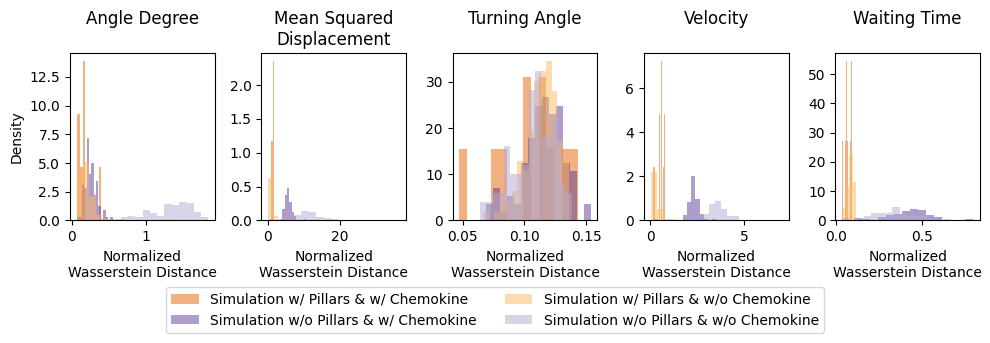

In [26]:
colors = ['#e66101', '#5e3c99', '#fdb863', '#b2abd2']
if posterior_sim_nn_bf_no_pillars_chemokine is not None:
    labels = ['Simulation w/ Pillars & w/ Chemokine',
          'Simulation w/o Pillars & w/ Chemokine',
          'Simulation w/ Pillars & w/o Chemokine',
          'Simulation w/o Pillars & w/o Chemokine']

    sumstats_bf = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in posterior_sim_nn_bf]
    sumstats_bf_p = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in posterior_sim_nn_bf_no_pillars]
    sumstats_bf_c = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in posterior_sim_nn_bf_no_chemokine]
    sumstats_bf_pc = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in posterior_sim_nn_bf_no_pillars_chemokine]

    plot_sumstats_distance_hist(obj_func_wass, make_sumstat_dict(test_sim), [sumstats_bf, sumstats_bf_p, sumstats_bf_c, sumstats_bf_pc],
                                    labels=labels,
                                    colors=colors,
                                    path=os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_sumstats_wasserstein_conditions_chemokine.png')
                                    )

/Users/jonas.arruda/PyCharm Projects/CellMigration/synth_data_params_bayesflow/summary_stats.py:200: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/Users/jonas.arruda/PyCharm Projects/CellMigration/synth_data_params_bayesflow/summary_stats.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice.
  return np.nanvar(x)


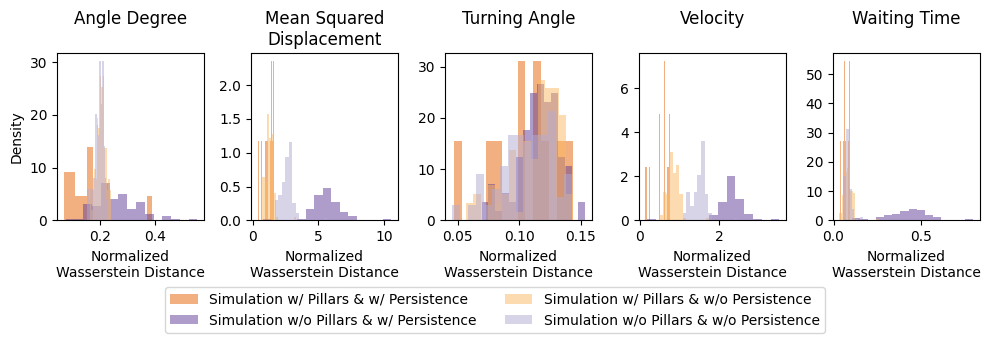

In [27]:
if posterior_sim_nn_bf_no_pillars_persistent is not None:
    labels = ['Simulation w/ Pillars & w/ Persistence',
          'Simulation w/o Pillars & w/ Persistence',
          'Simulation w/ Pillars & w/o Persistence',
          'Simulation w/o Pillars & w/o Persistence']

    sumstats_bf = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in posterior_sim_nn_bf]
    sumstats_bf_p = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in posterior_sim_nn_bf_no_pillars]
    sumstats_bf_per = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in posterior_sim_nn_bf_no_persistent]
    sumstats_bf_pper = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in posterior_sim_nn_bf_no_pillars_persistent]

    plot_sumstats_distance_hist(obj_func_wass, make_sumstat_dict(test_sim), [sumstats_bf, sumstats_bf_p, sumstats_bf_per, sumstats_bf_pper],
                                    labels=labels,
                                    colors=colors,
                                    path=os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_sumstats_wasserstein_conditions_persistence.png')
                                )

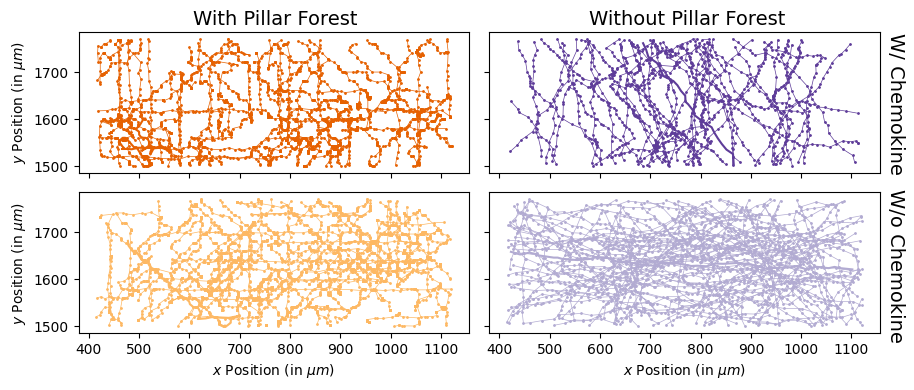

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                       tight_layout=True, figsize=(9, 4))
ax = ax.flatten()

pop_id = 0
cell_popiulatinos = [posterior_sim_nn_bf[pop_id], posterior_sim_nn_bf_no_pillars[pop_id],
                     posterior_sim_nn_bf_no_chemokine[pop_id], posterior_sim_nn_bf_no_pillars_chemokine[pop_id]]

# Add labels to the top and right side
ax[1].set_title(' ')  # to have space for the different labels
fig.text(0.22, 0.94, 'With Pillar Forest', va='center', fontsize=14)
fig.text(0.66, 0.94, 'Without Pillar Forest', va='center', fontsize=14)
fig.text(0.99, 0.73, 'W/ Chemokine', va='center', rotation=270, fontsize=14) # Right side label
fig.text(0.99, 0.325, 'W/o Chemokine', va='center', rotation=270, fontsize=14)

for i, cp in enumerate(cell_popiulatinos):
    ax[i].plot(cp[0, :, 0], cp[0, :, 1], color=colors[i])
    for cell_id in range(1, cells_in_population):
        ax[i].plot(cp[cell_id, :, 0], cp[cell_id, :, 1], linewidth=0.5, color=colors[i])
        ax[i].scatter(cp[cell_id, :, 0], cp[cell_id, :, 1], s=1, color=colors[i])

ax[0].set_ylabel('$y$ Position (in $\mu m$)')
ax[2].set_ylabel('$y$ Position (in $\mu m$)')
ax[2].set_xlabel('$x$ Position (in $\mu m$)')
ax[3].set_xlabel('$x$ Position (in $\mu m$)')
plt.savefig(os.path.join(gp, f'{results_path}/simulated_trajectories_chemokine.png'), bbox_inches='tight')
plt.show()

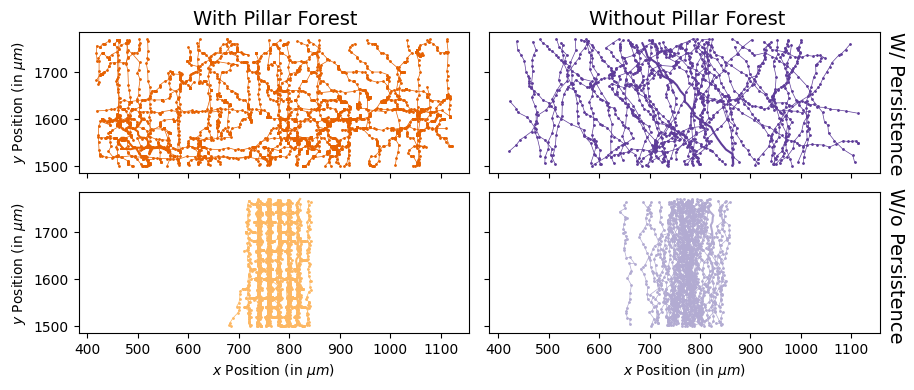

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                       tight_layout=True, figsize=(9, 4))
ax = ax.flatten()

cell_popiulatinos = [posterior_sim_nn_bf[pop_id], posterior_sim_nn_bf_no_pillars[pop_id],
                     posterior_sim_nn_bf_no_persistent[pop_id], posterior_sim_nn_bf_no_pillars_persistent[pop_id]]
colors = ['#e66101', '#5e3c99', '#fdb863', '#b2abd2']

# Add labels to the top and right side
ax[1].set_title(' ')  # to have space for the different labels
fig.text(0.22, 0.94, 'With Pillar Forest', va='center', fontsize=14)
fig.text(0.66, 0.94, 'Without Pillar Forest', va='center', fontsize=14)
fig.text(0.99, 0.73, 'W/ Persistence', va='center', rotation=270, fontsize=14) # Right side label
fig.text(0.99, 0.325, 'W/o Persistence', va='center', rotation=270, fontsize=14)

for i, cp in enumerate(cell_popiulatinos):
    ax[i].plot(cp[0, :, 0], cp[0, :, 1], color=colors[i])
    for cell_id in range(1, cells_in_population):
        ax[i].plot(cp[cell_id, :, 0], cp[cell_id, :, 1], linewidth=0.5, color=colors[i])
        ax[i].scatter(cp[cell_id, :, 0], cp[cell_id, :, 1], s=1, color=colors[i])

ax[0].set_ylabel('$y$ Position (in $\mu m$)')
ax[2].set_ylabel('$y$ Position (in $\mu m$)')
ax[2].set_xlabel('$x$ Position (in $\mu m$)')
ax[3].set_xlabel('$x$ Position (in $\mu m$)')
plt.savefig(os.path.join(gp, f'{results_path}/simulated_trajectories_persistence.png'), bbox_inches='tight')
plt.show()

In [30]:
msd_lags_pc = compute_MSD_lags(posterior_sim_nn_bf_no_pillars_chemokine[pop_id])
msd_lags_p = compute_MSD_lags(posterior_sim_nn_bf_no_pillars[pop_id])
msd_lags_c = compute_MSD_lags(posterior_sim_nn_bf_no_chemokine[pop_id])
msd_lags_per = compute_MSD_lags(posterior_sim_nn_bf_no_persistent[pop_id])
msd_lags_pper = compute_MSD_lags(posterior_sim_nn_bf_no_pillars_persistent[pop_id])
msd_lags_sim = compute_MSD_lags(posterior_sim_nn_bf[pop_id])

# msd_lags_pc = np.concatenate([compute_MSD_lags(ps) for ps in posterior_sim_nn_bf_no_pillars_chemokine])
# msd_lags_p = np.concatenate([compute_MSD_lags(ps) for ps in posterior_sim_nn_bf_no_pillars])
# msd_lags_c = np.concatenate([compute_MSD_lags(ps) for ps in posterior_sim_nn_bf_no_chemokine])
# msd_lags_sim = np.concatenate([compute_MSD_lags(ps) for ps in posterior_sim_nn_bf])

msd_lags_real = compute_MSD_lags(test_sim[0])

/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/ipykernel_5478/939417259.py:14: RuntimeWarning: Mean of empty slice
  mean_msd_test = np.where(valid_counts > 1, np.nanmean(msd_lags, axis=0), np.nan)
/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


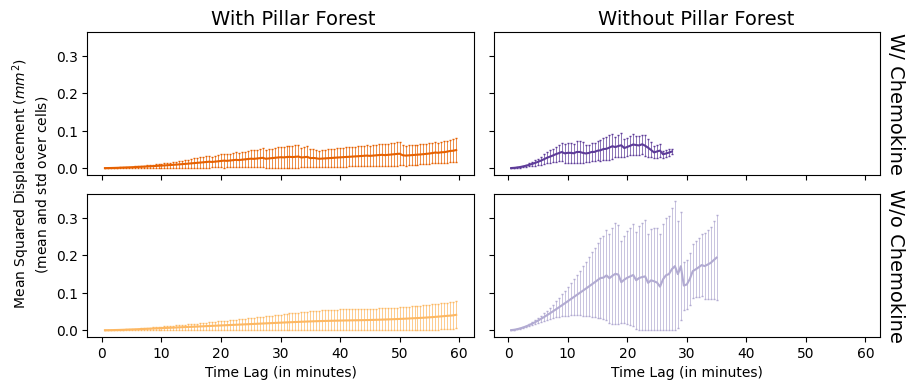

In [31]:
msd_lags_list = [msd_lags_sim, msd_lags_p, msd_lags_c, msd_lags_pc]
labels = ['Simulation w/ Pillars & Chemokine',
          'Simulation w/o Pillars & w/ Chemokine',
          'Simulation w/ Pillars & w/o Chemokine',
          'Simulation w/o Pillars & Chemokine']
colors = ['#e66101', '#5e3c99', '#fdb863', '#b2abd2']
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 4), tight_layout=True)
ax = ax.flatten()

for i, (msd_lags, l) in enumerate(zip(msd_lags_list, labels)):

    # Compute valid counts along the axis (non-NaN entries)
    valid_counts = np.sum(~np.isnan(msd_lags), axis=0)
    mean_msd_test = np.where(valid_counts > 1, np.nanmean(msd_lags, axis=0), np.nan)
    yerr_test = np.where(valid_counts > 1, np.nanstd(msd_lags, axis=0), np.nan)

    # Clip error bars to avoid negative values for plotted range
    lower_bound_test = np.maximum(mean_msd_test - yerr_test, 0)
    upper_bound_test = mean_msd_test + yerr_test

    ax[i].errorbar(np.arange(1, msd_lags.shape[1] + 1) * 30 / 60,
                   mean_msd_test/ 1e6,
                   yerr=[(mean_msd_test - lower_bound_test) / 1e6, (upper_bound_test - mean_msd_test) / 1e6],
                   capsize=1, elinewidth=0.5, label=l, color=colors[i]
                   )
ax[1].set_title(' ')  # to have space for the different labels

# Add labels to the top and right side
fig.text(0.24, 0.94, 'With Pillar Forest', va='center', fontsize=14)
fig.text(0.67, 0.94, 'Without Pillar Forest', va='center', fontsize=14)
fig.text(0.99, 0.73, 'W/ Chemokine', va='center', rotation=270, fontsize=14) # Right side label
fig.text(0.99, 0.325, 'W/o Chemokine', va='center', rotation=270, fontsize=14)

ax[2].set_ylabel('$\qquad\qquad\qquad\qquad\qquad\qquad$ Mean Squared Displacement ($mm^2$)\n$\qquad\qquad\qquad\qquad\qquad\qquad$(mean and std over cells)')
ax[2].set_xlabel('Time Lag (in minutes)')
ax[3].set_xlabel('Time Lag (in minutes)')
plt.savefig(os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_msd_lags_chemokine.png'), bbox_inches='tight')
plt.show()

/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/ipykernel_5478/3912050179.py:14: RuntimeWarning: Mean of empty slice
  mean_msd_test = np.where(valid_counts > 1, np.nanmean(msd_lags, axis=0), np.nan)
/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


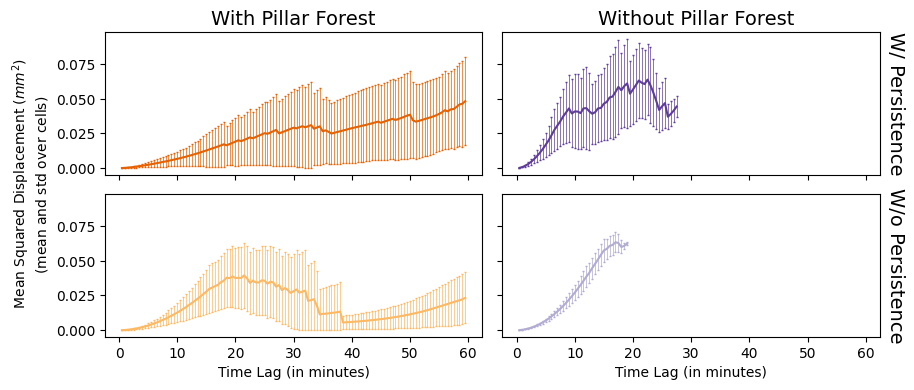

In [32]:
msd_lags_list = [msd_lags_sim, msd_lags_p, msd_lags_per, msd_lags_pper]
labels = ['Simulation w/ Pillars & Persistence',
          'Simulation w/o Pillars & w/ Persistence',
          'Simulation w/ Pillars & w/o Persistence',
          'Simulation w/o Pillars & Persistence']
colors = ['#e66101', '#5e3c99', '#fdb863', '#b2abd2']
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 4), tight_layout=True)
ax = ax.flatten()

for i, (msd_lags, l) in enumerate(zip(msd_lags_list, labels)):

    # Compute valid counts along the axis (non-NaN entries)
    valid_counts = np.sum(~np.isnan(msd_lags), axis=0)
    mean_msd_test = np.where(valid_counts > 1, np.nanmean(msd_lags, axis=0), np.nan)
    yerr_test = np.where(valid_counts > 1, np.nanstd(msd_lags, axis=0), np.nan)

    # Clip error bars to avoid negative values for plotted range
    lower_bound_test = np.maximum(mean_msd_test - yerr_test, 0)
    upper_bound_test = mean_msd_test + yerr_test

    ax[i].errorbar(np.arange(1, msd_lags.shape[1] + 1) * 30 / 60,
                   mean_msd_test/ 1e6,
                   yerr=[(mean_msd_test - lower_bound_test) / 1e6, (upper_bound_test - mean_msd_test) / 1e6],
                   capsize=1, elinewidth=0.5, label=l, color=colors[i]
                   )
ax[1].set_title(' ')  # to have space for the different labels

# Add labels to the top and right side
fig.text(0.24, 0.94, 'With Pillar Forest', va='center', fontsize=14)
fig.text(0.67, 0.94, 'Without Pillar Forest', va='center', fontsize=14)
fig.text(0.99, 0.73, 'W/ Persistence', va='center', rotation=270, fontsize=14) # Right side label
fig.text(0.99, 0.325, 'W/o Persistence', va='center', rotation=270, fontsize=14)

ax[2].set_ylabel('$\qquad\qquad\qquad\qquad\qquad\qquad$ Mean Squared Displacement ($mm^2$)\n$\qquad\qquad\qquad\qquad\qquad\qquad$(mean and std over cells)')
ax[2].set_xlabel('Time Lag (in minutes)')
ax[3].set_xlabel('Time Lag (in minutes)')
plt.savefig(os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_msd_lags_persistence.png'), bbox_inches='tight')
plt.show()

/Users/jonas.arruda/PyCharm Projects/CellMigration/synth_data_params_bayesflow/summary_stats.py:200: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/Users/jonas.arruda/PyCharm Projects/CellMigration/synth_data_params_bayesflow/summary_stats.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice.
  return np.nanvar(x)


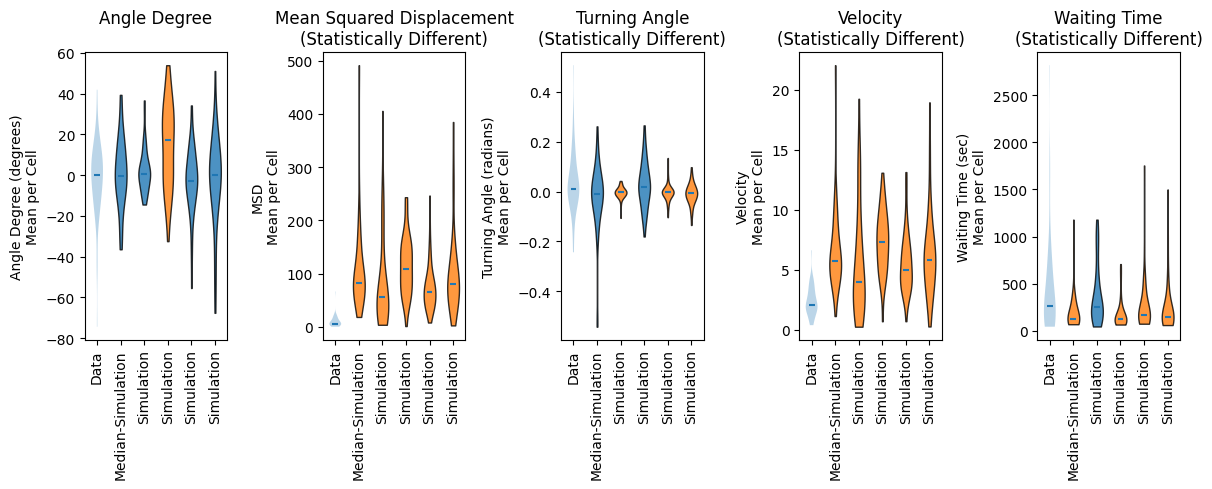

Wasserstein distance: 330.5173478327865


In [33]:
# plot the summary statistics
if posterior_sim_nn_abc is not None:
    plot_compare_summary_stats(test_sim, posterior_sim_nn_abc)
plot_compare_summary_stats(test_sim, posterior_sim_nn_bf);

In [ ]:
all_trajec = np.concatenate([
    test_sim[0],
    posterior_sim_nn_abc[0],
    posterior_sim_nn_bf[0],
])
all_trajec = np.concatenate([all_trajec[..., 0], all_trajec[..., 1]], axis=1)
all_trajec[np.isnan(all_trajec)] = -1

color_code = np.concatenate([
    np.zeros(test_sim[0].shape[0]), 
    np.ones(posterior_sim_nn_abc[0].shape[0]),
    np.ones(posterior_sim_nn_bf[0].shape[0])*2
])

# make a umap plot
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
reducer = umap.UMAP(random_state=0, n_jobs=1)
embedding = reducer.fit_transform(all_trajec)

plt.figure(tight_layout=True, figsize=(5, 5))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[colors[int(i)] for i in color_code],
    alpha=0.5,
)
plt.gca().set_aspect('equal', 'datalim')
patches = [Patch(color=colors[i], label=f'{["Real", "ABC", "NPE"][i]}') for i in range(len(colors))]
plt.legend(handles=patches)
plt.title('UMAP Trajectory Projection')
plt.savefig(os.path.join(gp, f'{results_path}/{"synthetic" if load_synthetic_data else "real"}_umap_trajectory_comparison.png'))
plt.show()

In [ ]:
def get_summary_vector(data):
    data = make_sumstat_dict_nn(data)
    data = np.concatenate([data['summary_net'], data['direct_conditions']])[np.newaxis]
    return data

In [ ]:
d1 = get_summary_vector(test_sim)
d2 = np.concatenate([get_summary_vector(sim[np.newaxis]) for sim in posterior_sim_nn_abc])
d3 = np.concatenate([get_summary_vector(sim[np.newaxis]) for sim in posterior_sim_nn_bf])
all_latent_trajec = np.concatenate([d1, d2, d3])

color_code = np.concatenate([
    np.zeros(d1.shape[0]), 
    np.ones(d2.shape[0]),
    np.ones(d3.shape[0])*2
])

In [ ]:
# make a umap plot
reducer = umap.UMAP(random_state=42, n_jobs=1, metric='manhattan')
embedding = reducer.fit_transform(all_latent_trajec)

plt.figure(tight_layout=True, figsize=(5, 5))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[colors[int(i)] for i in color_code],
    alpha=0.7,
)
plt.gca().set_aspect('equal', 'datalim')
patches = [Patch(color=colors[i], label=f'{["Real", "ABC", "NPE"][i]}') for i in range(len(colors))]
plt.legend(handles=patches)
plt.title('UMAP Latent Summary Projection')
plt.show()